<a href="https://colab.research.google.com/github/hardaatbaath/BITS_F464_ML_Project/blob/main/Stock_Market_Prediction_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up the Environment

## Importing the Libraries

In [1]:
# To get run time for each cell
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
time: 20.7 ms (started: 2024-04-15 10:22:23 +00:00)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

time: 2.68 s (started: 2024-04-15 10:22:23 +00:00)


## Declaring the Models

In [3]:
# Linear Regression
linear_model = LinearRegression()

# Decision Tree Regression
tree_model = DecisionTreeRegressor()

# Random Forest Regression
forest_model = RandomForestRegressor()

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()

# Support Vector Machine Regression
svm_model = SVR()

# Multi-layer Perceptron Regression
mlp_model = MLPRegressor()

time: 982 µs (started: 2024-04-15 10:22:25 +00:00)


## Declaring Utility Functions

In [4]:
def prepare_data(df, forecast_out, test_size, pred_size):
    """
    Prepare data for time series forecasting.

    Parameters:
    df (DataFrame): Input DataFrame containing the data.
    forecast_out (int): Number of periods to forecast.
    test_size (float): Proportion of the dataset to include in the test split.
    pred_size (float): Proportion of the dataset to include in the prediction split

    Returns:
    list: List containing [X_train, X_test, Y_train, Y_test, X_pred, Y_pred, X_lately].
    """
    forecast_col = "Close"

    label = df[forecast_col].shift(-forecast_out) # creating new column called label with the last forecast_out rows as NaN

    X = np.array(df[["Close", "Open", "High", "Low"]]) # creating the feature array

    X = preprocessing.scale(X) # processing the feature array

    X_lately = X[-forecast_out:] # creating the column I want to use later in the predicting method

    X = X[:-forecast_out] # X that will contain the training, testing, and prediction data

    label.dropna(inplace=True) # dropping NaN values

    y = np.array(label)  # assigning Y

    # Splitting the data into train and prediction sets based on pred_size
    split_index = int((1 - pred_size) * len(X))

    X_train_pred = X[:split_index]  # part of X to be used for train_test_split
    X_pred = X[split_index - 1:]  # part of X to be used for prediction
    Y_train_pred = y[:split_index]  # part of Y to be used for train_test_split
    Y_pred = y[split_index - 1:]       # part of Y to be used for prediction plotting
    Y_full = y

    # Further splitting the X_train_pred and Y_train_pred into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_train_pred, Y_train_pred, test_size=test_size, random_state=0) # cross validation

    response = [X_train, X_test, Y_train, Y_test, X_pred, Y_pred, X_lately, Y_full]
    return response

time: 1.37 ms (started: 2024-04-15 10:22:25 +00:00)


In [5]:
def plot_r2_loss(model, forecast_out_values, test_sizes, pred_size):
    """
    Plot the accuracy of the model for different forecast_out values and test sizes.

    Parameters:
    - model: Trained regression model.
    - forecast_out_values: List of forecast_out values to test.
    - test_sizes: List of test sizes for train_test_split.
    """
    plt.figure(figsize=(12, 8))

    for test_size in test_sizes:
        accuracies = []

        for forecast_out in forecast_out_values:
            # Prepare data for the current forecast_out
            X_train, X_test, Y_train, Y_test, X_pred, Y_pred, X_lately, _ = prepare_data(df, forecast_out, test_size, pred_size)

            # Train the model
            model.fit(X_train, Y_train)

            # Test the model
            score = model.score(X_test, Y_test)

            # Store accuracy
            accuracies.append(score)

        # Plotting accuracy for the current test_size
        plt.plot(forecast_out_values, accuracies, marker='o', label=f'Test Size: {test_size}')

    # Plot settings
    plt.xlabel('Forecast Out')
    plt.ylabel('Accuracy (R^2 Score)')
    plt.title('Accuracy vs Forecast Out for Different Test Sizes')
    plt.grid(True)
    plt.legend(title='Test Size')
    plt.show()


time: 1.15 ms (started: 2024-04-15 10:22:25 +00:00)


In [6]:
def plot_forecast_predictions(df, model, forecast_out_values, test_size, pred_size):
    """
    Plot the actual and predicted values for various forecast_out values using Plotly.

    Parameters:
    - df (DataFrame): Input DataFrame containing the data.
    - model: Trained regression model.
    - forecast_out_values: List of forecast_out values to test.
    - test_size: Test size for train_test_split.
    - pred_size: Proportion of the dataset to include in the prediction split.
    """
    fig = go.Figure()

    for forecast_out in forecast_out_values:
        # Prepare data for the current forecast_out
        X_train, X_test, Y_train, Y_test, X_pred, Y_pred, X_lately, Y_full = prepare_data(df, forecast_out, test_size, pred_size)

        # Train the model
        model.fit(X_train, Y_train)

        # Predictions
        Y_pred = model.predict(X_pred)

        # Plotting predictions
        start_idx = len(Y_full) - len(Y_pred)
        end_idx = len(Y_full)
        fig.add_trace(go.Scatter(x=np.arange(start_idx, end_idx), y=Y_pred, mode='lines', name=f'Forecast Out: {forecast_out}'))

    # Plot actual values
    fig.add_trace(go.Scatter(x=np.arange(len(Y_full)), y=Y_full, mode='lines', name='Actual Values', line=dict(color='orange', width=2)))

    # Update layout
    fig.update_layout(title='Actual vs Predicted Values Across Different Forecast Periods',
                      xaxis_title='Index',
                      yaxis_title='Value',
                      showlegend=True,
                      legend=dict(x=0, y=1),
                      height=600,
                      width=1000)

    fig.show()

time: 827 µs (started: 2024-04-15 10:22:25 +00:00)


## Downloading and Exploring the Stock Data

In [7]:
# The data is uploaded to Google Colab and is uploaded on GitHub

df = pd.read_csv("/content/TATASTEEL.csv")

df.drop(columns=['Trades', 'Deliverable Volume', '%Deliverble', 'Date', 'Symbol', 'Series'], inplace=True)

time: 47.9 ms (started: 2024-04-15 10:22:25 +00:00)


In [8]:
df.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,142.35,148.00,153.2,146.10,152.50,152.45,150.92,2003185,3.023164e+13
1,152.45,150.10,153.0,143.05,151.95,150.80,151.03,1555136,2.348785e+13
2,150.80,144.60,162.9,144.60,158.00,156.55,156.85,3840284,6.023364e+13
3,156.55,158.95,169.1,158.95,169.00,168.25,167.61,2560449,4.291530e+13
4,168.25,173.40,179.0,166.30,170.55,171.95,173.89,3641691,6.332459e+13


time: 40.1 ms (started: 2024-04-15 10:22:26 +00:00)


In [9]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03
mean,403.385658,404.253581,411.210460,396.509197,403.467414,403.553703,404.062991,6.165253e+06,2.664876e+14
std,187.146366,187.559958,190.791329,183.858461,187.265190,187.312178,187.436529,5.329084e+06,3.012861e+14
min,67.250000,66.000000,69.700000,66.000000,67.300000,67.250000,67.970000,2.329100e+04,2.159165e+11
25%,275.775000,275.600000,284.412500,270.000000,275.812500,275.937500,276.935000,2.801380e+06,1.118719e+14
50%,402.850000,403.000000,409.375000,396.650000,402.700000,402.900000,403.430000,4.800300e+06,1.949303e+14
75%,523.987500,525.000000,534.725000,516.487500,523.950000,524.075000,525.230000,7.833888e+06,3.379640e+14
max,1031.350000,1024.000000,1052.600000,1011.100000,1035.000000,1034.000000,1031.950000,6.428460e+07,4.881124e+15


time: 47.7 ms (started: 2024-04-15 10:22:26 +00:00)


In [10]:
df.corr()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
Prev Close,1.000000,0.999356,0.998831,0.998428,0.997891,0.998023,0.998889,0.169009,0.422736
Open,0.999356,1.000000,0.999060,0.998755,0.997966,0.998093,0.998966,0.169228,0.423302
High,0.998831,0.999060,1.000000,0.998301,0.998956,0.999032,0.999429,0.179186,0.432111
Low,0.998428,0.998755,0.998301,1.000000,0.998967,0.999057,0.999427,0.166597,0.422558
Last,0.997891,0.997966,0.998956,0.998967,1.000000,0.999966,0.999589,0.176382,0.430660
Close,0.998023,0.998093,0.999032,0.999057,0.999966,1.000000,0.999678,0.176225,0.430538
VWAP,0.998889,0.998966,0.999429,0.999427,0.999589,0.999678,1.000000,0.173956,0.428495
Volume,0.169009,0.169228,0.179186,0.166597,0.176382,0.176225,0.173956,1.000000,0.884733
Turnover,0.422736,0.423302,0.432111,0.422558,0.430660,0.430538,0.428495,0.884733,1.000000


time: 32 ms (started: 2024-04-15 10:22:26 +00:00)


In [11]:
forecast_out = 5
test_size = 0.3
pred_size = 0.2

# Getting the trainig, testing and prediction data
X_train, X_test, Y_train, Y_test, X_pred, Y_pred, X_lately, Y_full =prepare_data(df,forecast_out,test_size, pred_size) #calling the method were the cross validation and data preperation is in


time: 5.38 ms (started: 2024-04-15 10:22:26 +00:00)


In [12]:
# Printing the size of the data
print(f"X_train shape {X_train.shape}")
print(f"Y_train shape {Y_train.shape}")
print(f"X_test shape {X_test.shape}")
print(f"Y_test shape {Y_test.shape}")
print(f"X_pred shape {X_pred.shape}")
print(f"Y_pred shape {Y_pred.shape}")
print(f"X_lately shape {X_lately.shape}")
print(f"Y_full shape {Y_full.shape}")

X_train shape (2968, 4)
Y_train shape (2968,)
X_test shape (1272, 4)
Y_test shape (1272,)
X_pred shape (1062, 4)
Y_pred shape (1062,)
X_lately shape (5, 4)
Y_full shape (5301,)
time: 1.32 ms (started: 2024-04-15 10:22:26 +00:00)


In [13]:
accuracy = np.array([])
forecast_set = np.array([])

time: 1.02 ms (started: 2024-04-15 10:22:26 +00:00)


# Prediction using Linear Regression

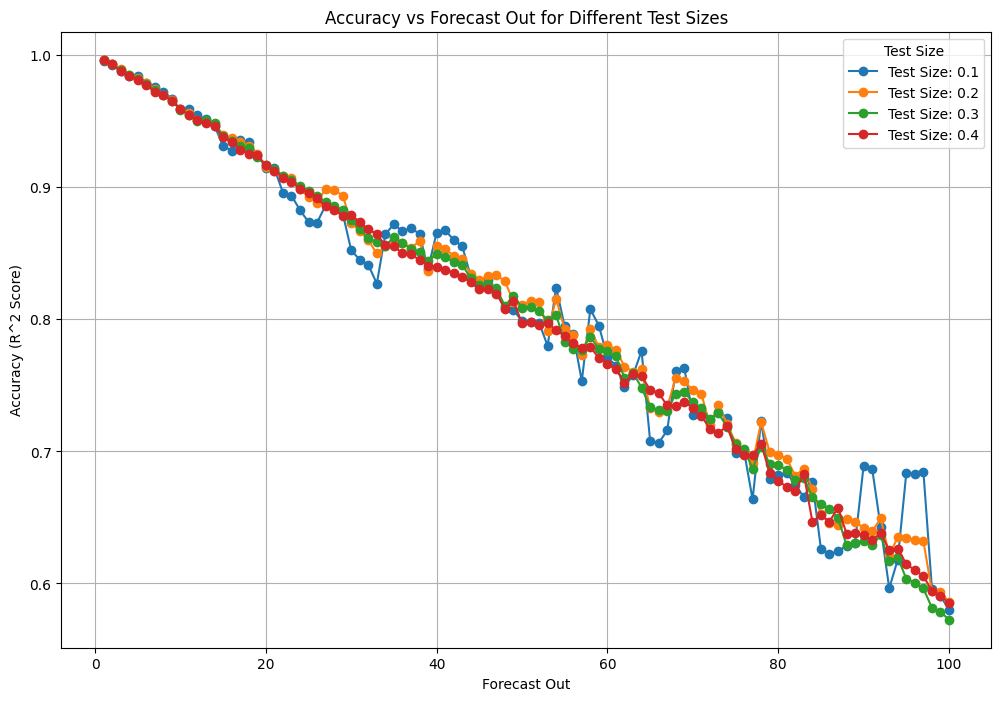

time: 2.62 s (started: 2024-04-15 10:22:26 +00:00)


In [14]:
forecast_out_values = np.arange(1, 101, 1)
train_test_splits = [0.1, 0.2, 0.3, 0.4]
plot_r2_loss(linear_model, forecast_out_values, train_test_splits, pred_size)

In [15]:
plot_forecast_predictions(df, linear_model, [1, 5, 10], 0.2, 0.4)

time: 558 ms (started: 2024-04-15 10:22:28 +00:00)


In [16]:
score = linear_model.score(X_test,Y_test)   #testing the linear regression model
forecast = linear_model.predict(X_lately)     #set that will contain the forecasted data
response = {}   #creting json object

# Store the next five predictions and accuracy in arrays
accuracy = np.append(accuracy, score)
forecast_set = np.append(forecast_set, forecast)

response['test_score'] = score
response['forecast_set'] = forecast

print(response)

{'test_score': 0.9819916793145599, 'forecast_set': array([ 929.82992057,  968.30458287,  956.07940933, 1023.64692638,
       1021.58938982])}
time: 5.27 ms (started: 2024-04-15 10:22:29 +00:00)


# Predicting using Decision Tree

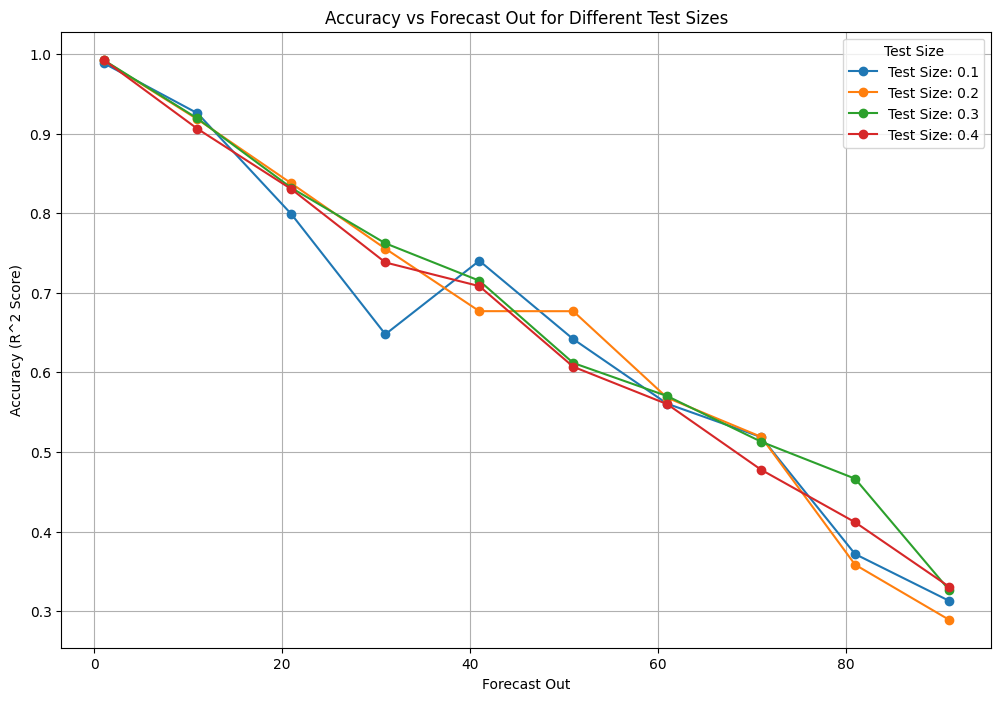

time: 1.8 s (started: 2024-04-15 10:22:29 +00:00)


In [17]:
forecast_out_values = np.arange(1, 101, 10)
train_test_splits = [0.1, 0.2, 0.3, 0.4]
plot_r2_loss(tree_model, forecast_out_values, train_test_splits, pred_size)

In [18]:
plot_forecast_predictions(df, tree_model, [1, 5, 10], 0.2, 0.4)

time: 119 ms (started: 2024-04-15 10:22:31 +00:00)


In [19]:
score = tree_model.score(X_test,Y_test)   #testing the linear regression model
forecast = tree_model.predict(X_lately)     #set that will contain the forecasted data
response = {}   #creting json object

# Store the next five predictions and accuracy in arrays
accuracy = np.append(accuracy, score)
forecast_set = np.append(forecast_set, forecast)

response['test_score'] = score
response['forecast_set'] = forecast

print(response)

{'test_score': 0.9608142899027098, 'forecast_set': array([852.1, 852.1, 834. , 834. , 834. ])}
time: 7.66 ms (started: 2024-04-15 10:22:31 +00:00)


# Prediction using Random Forest

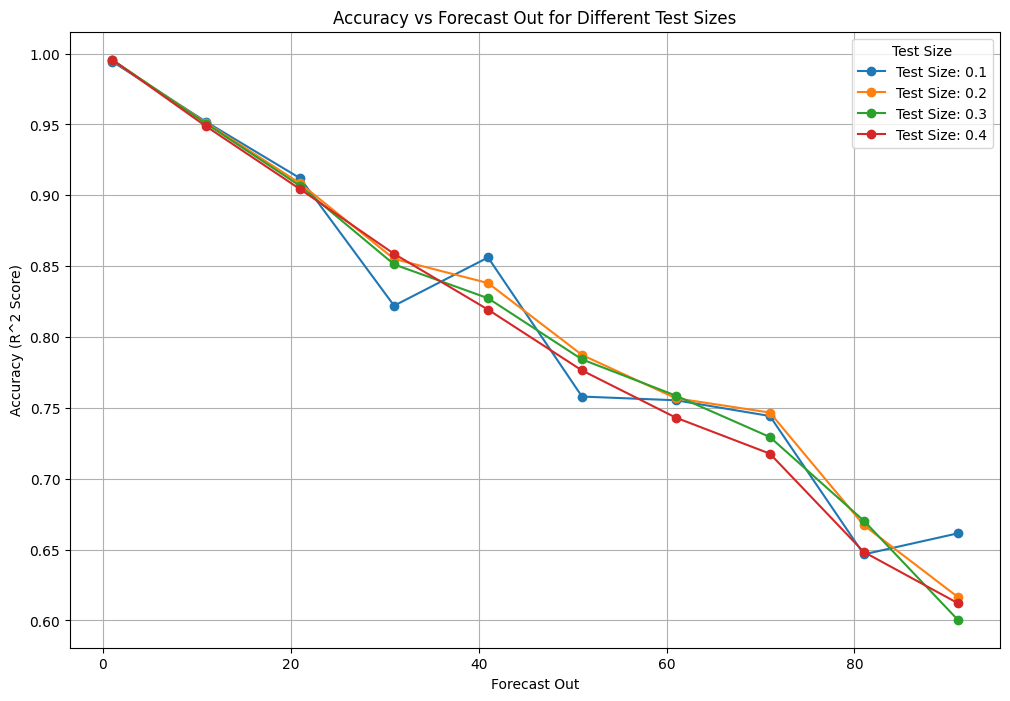

time: 1min 7s (started: 2024-04-15 10:22:31 +00:00)


In [20]:
forecast_out_values = np.arange(1, 101, 10)
train_test_splits = [0.1, 0.2, 0.3, 0.4]
plot_r2_loss(forest_model, forecast_out_values, train_test_splits, pred_size)

In [21]:
plot_forecast_predictions(df, forest_model, [1, 5, 10], 0.2, 0.4)

time: 2.93 s (started: 2024-04-15 10:23:38 +00:00)


In [22]:
score = forest_model.score(X_test,Y_test)   #testing the linear regression model
forecast = forest_model.predict(X_lately)     #set that will contain the forecasted data
response = {}   #creting json object

# Store the next five predictions and accuracy in arrays
accuracy = np.append(accuracy, score)
forecast_set = np.append(forecast_set, forecast)

response['test_score'] = score
response['forecast_set'] = forecast

print(response)

{'test_score': 0.9806746782850639, 'forecast_set': array([833.218, 832.122, 830.996, 831.606, 831.606])}
time: 57.1 ms (started: 2024-04-15 10:23:41 +00:00)


# Prediction using K-nearest Neighbours

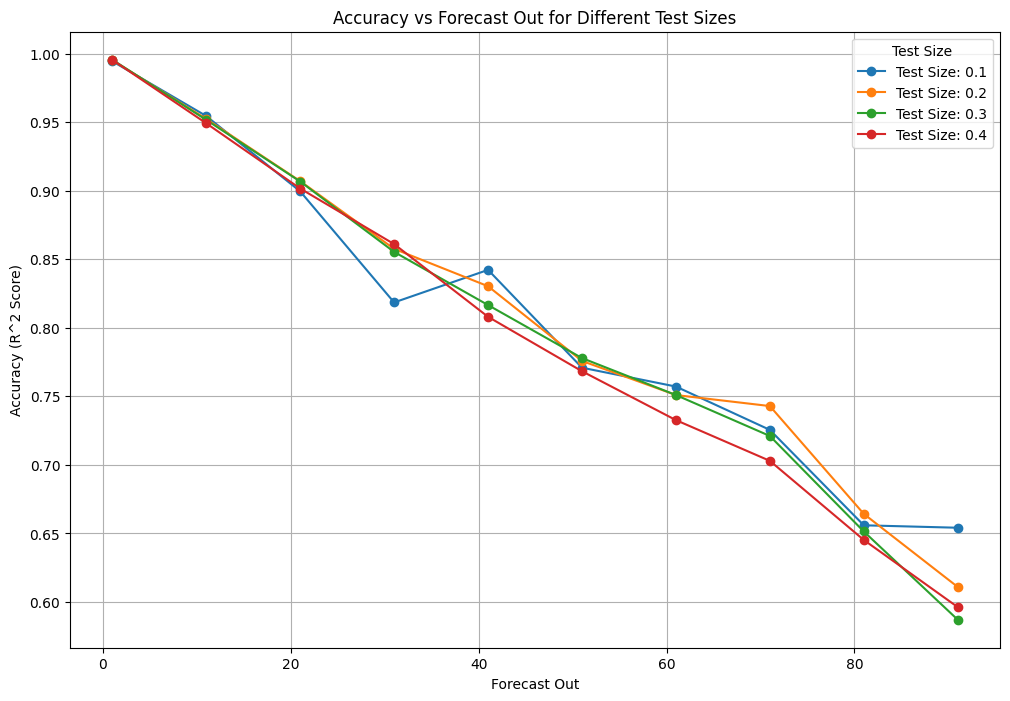

time: 679 ms (started: 2024-04-15 10:23:41 +00:00)


In [23]:
forecast_out_values = np.arange(1, 101, 10)
train_test_splits = [0.1, 0.2, 0.3, 0.4]
plot_r2_loss(knn_model, forecast_out_values, train_test_splits, pred_size)

In [24]:
plot_forecast_predictions(df, knn_model, [1, 5, 10], 0.2, 0.4)

time: 60.9 ms (started: 2024-04-15 10:23:42 +00:00)


In [25]:
score = knn_model.score(X_test,Y_test)   #testing the linear regression model
forecast = knn_model.predict(X_lately)     #set that will contain the forecasted data
response = {}   #creting json object

# Store the next five predictions and accuracy in arrays
accuracy = np.append(accuracy, score)
forecast_set = np.append(forecast_set, forecast)

response['test_score'] = score
response['forecast_set'] = forecast

print(response)

{'test_score': 0.9769028761370712, 'forecast_set': array([801.03, 826.31, 825.47, 830.96, 830.96])}
time: 11.2 ms (started: 2024-04-15 10:23:42 +00:00)


# Prediction using Support Vector Machines

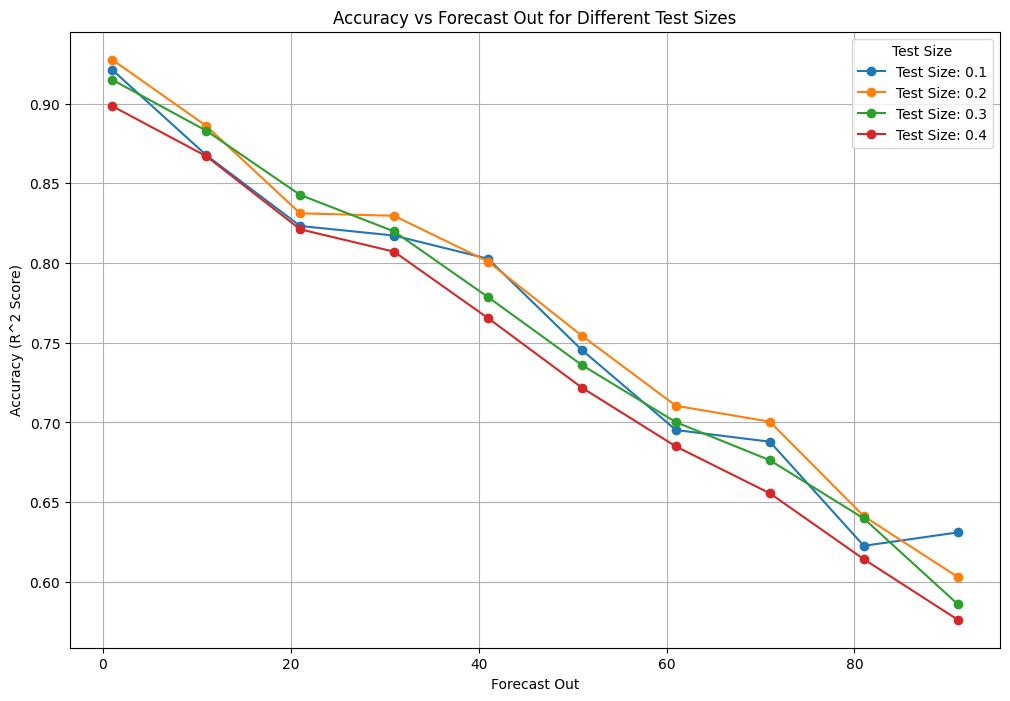

time: 28.1 s (started: 2024-04-15 10:23:42 +00:00)


In [26]:
forecast_out_values = np.arange(1, 101, 10)
train_test_splits = [0.1, 0.2, 0.3, 0.4]
plot_r2_loss(svm_model, forecast_out_values, train_test_splits, pred_size)

In [27]:
plot_forecast_predictions(df, svm_model, [1, 5, 10], 0.2, 0.4)

time: 2.93 s (started: 2024-04-15 10:24:10 +00:00)


In [28]:
score = svm_model.score(X_test,Y_test)   #testing the linear regression model
forecast = svm_model.predict(X_lately)     #set that will contain the forecasted data
response = {}   #creting json object

# Store the next five predictions and accuracy in arrays
accuracy = np.append(accuracy, score)
forecast_set = np.append(forecast_set, forecast)

response['test_score'] = score
response['forecast_set'] = forecast

print(response)

{'test_score': 0.9009357840966846, 'forecast_set': array([520.18756153, 504.75254977, 496.49587881, 476.21016494,
       464.42848757])}
time: 238 ms (started: 2024-04-15 10:24:13 +00:00)


# Prediction using Multi Layer Perceptron

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum

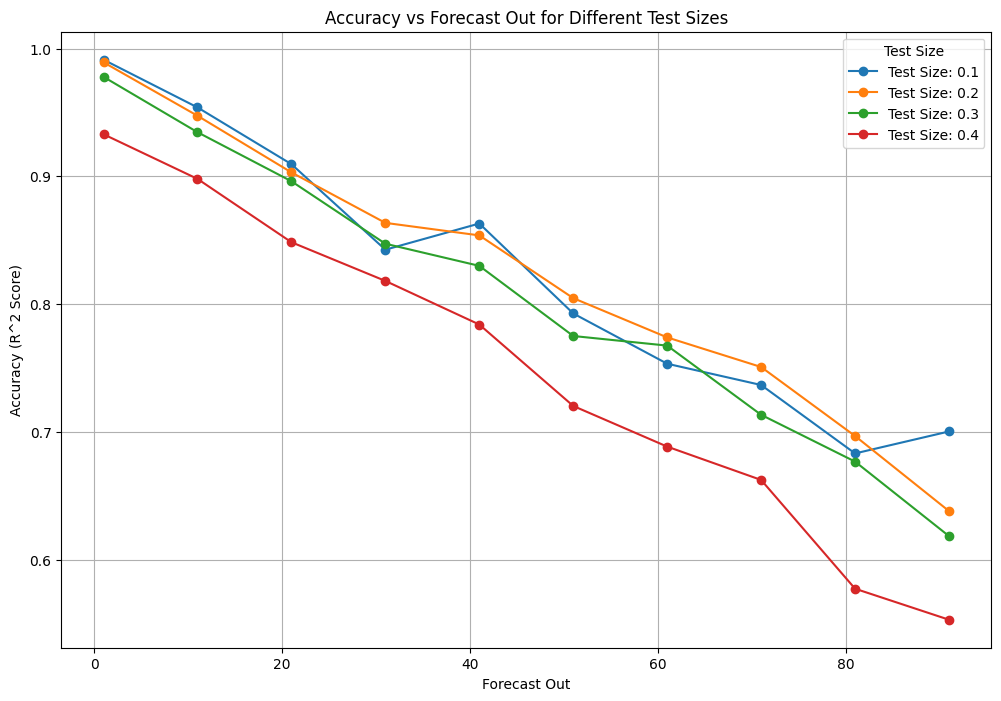

time: 2min 30s (started: 2024-04-15 10:24:14 +00:00)


In [29]:
forecast_out_values = np.arange(1, 101, 10)
train_test_splits = [0.1, 0.2, 0.3, 0.4]
plot_r2_loss(mlp_model, forecast_out_values, train_test_splits, pred_size)

In [30]:
plot_forecast_predictions(df, mlp_model, [1, 5, 10], 0.2, 0.4)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



time: 8.12 s (started: 2024-04-15 10:26:44 +00:00)


In [31]:
score = mlp_model.score(X_test,Y_test)   #testing the linear regression model
forecast = mlp_model.predict(X_lately)     #set that will contain the forecasted data
response = {}   #creting json object

# Store the next five predictions and accuracy in arrays
accuracy = np.append(accuracy, score)
forecast_set = np.append(forecast_set, forecast)

response['test_score'] = score
response['forecast_set'] = forecast

print(response)

{'test_score': 0.9446564797899621, 'forecast_set': array([ 978.53538479, 1006.20880203, 1023.12405944, 1067.83986374,
       1097.7215156 ])}
time: 6.96 ms (started: 2024-04-15 10:26:53 +00:00)


# Output Analysis

In [32]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbours', 'Support Vector Machines', 'Multi Layer Perceptron']
times_taken_run = [67.3, 92.7, 292.0, 74.8, 179.0, 918.0]     # Data from one of the runs
times_taken_inference = [6.27, 4.89, 46, 10.3, 212.0, 4.1]    # Data from one of the runs

time: 749 µs (started: 2024-04-15 10:26:53 +00:00)


In [33]:
# Plotting accuracy
fig = go.Figure(go.Bar(x=models, y=accuracy,
                       marker=dict(color='blue'),
                       text=accuracy,
                       textposition='auto'))  # Display text on the bars

fig.update_layout(title='Model Accuracies',
                  xaxis_title='Models',
                  yaxis_title='Accuracy',
                  yaxis_range=[0, 1])
fig.show()

time: 41.4 ms (started: 2024-04-15 10:26:53 +00:00)


In [34]:
# Plotting forecasted values for the next five points
fig = go.Figure()
forecast_set = forecast_set.reshape(6, 5)

for i, forecast in enumerate(forecast_set):
    fig.add_trace(go.Scatter(x=np.arange(len(forecast)), y=forecast, mode='lines+markers', name=models[i]))

fig.update_layout(title='Next Five Forecasted Points',
                  xaxis_title='Point Index',
                  yaxis_title='Forecasted Value',
                  legend=dict(x=0, y=1))
fig.show()

time: 28.4 ms (started: 2024-04-15 10:26:53 +00:00)


In [35]:
# Plotting time taken
fig = go.Figure(go.Bar(x=models, y=times_taken_run, marker=dict(color='green')))
fig.update_layout(title='Time Taken to Run Each Model',
                  xaxis_title='Models',
                  yaxis_title='Time (seconds)')
fig.show()

time: 9.61 ms (started: 2024-04-15 10:26:53 +00:00)


In [36]:
# Plotting time taken
fig = go.Figure(go.Bar(x=models, y=times_taken_inference, marker=dict(color='green')))
fig.update_layout(title='Time Taken to Make Predictions',
                  xaxis_title='Models',
                  yaxis_title='Time (seconds)')
fig.show()

time: 13.3 ms (started: 2024-04-15 10:26:53 +00:00)


# Testing various models on a single stock

In [37]:
# Linear Regression
linear_model = LinearRegression()

# Decision Tree Regression
tree_model = DecisionTreeRegressor()

# Random Forest Regression
forest_model = RandomForestRegressor()

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()

# Support Vector Machine Regression
svm_model = SVR()

# Multi-layer Perceptron Regression
mlp_model = MLPRegressor()

time: 1.06 ms (started: 2024-04-15 10:26:53 +00:00)


In [38]:
def plot_model_predictions(models, df, df_name, model_names, forecast_out, test_size, pred_size):
    """
    Plot the model predictions along with the actual values for a given DataFrame and set of models.

    Parameters:
    - models (list): List of trained regression models.
    - df (DataFrame): Input DataFrame containing the data.
    - df_name (str): Name of the DataFrame/stock.
    - model_names (list): List of names for the models.
    - forecast_out (int): Number of periods to forecast.
    - test_size (float): Proportion of the dataset to include in the test split.
    - pred_size (float): Proportion of the dataset to include in the prediction split.

    Returns:
    None: Displays the plot.
    """
    # Initialize the Plotly figure
    fig = go.Figure()

    # Splitting the data
    X_train, X_test, Y_train, Y_test, X_pred, Y_pred, X_lately, Y_full = prepare_data(df, forecast_out, test_size, pred_size)

    # Train the models
    for model in models:
        model.fit(X_train, Y_train)

    # Add Y_full to the plot
    fig.add_trace(go.Scatter(x=np.arange(len(Y_full)), y=Y_full, mode='lines', name='Y_full', line=dict(color='black')))

    # Add model predictions to the plot
    for i, (model, name) in enumerate(zip(models, model_names)):
        Y_pred = model.predict(X_pred)
        start_idx = len(Y_full) - len(Y_pred)  # Start index for plotting the predictions
        fig.add_trace(go.Scatter(x=np.arange(start_idx, len(Y_full)), y=Y_pred, mode='lines', name=name))

    # Update layout
    fig.update_layout(title=f'Model Predictions vs Actual Values for {df_name}',
                      xaxis_title='Index',
                      yaxis_title='Value',
                      legend=dict(x=0, y=1),
                      showlegend=True)

    fig.show()

time: 1.39 ms (started: 2024-04-15 10:26:53 +00:00)


In [41]:
forecast_out = 1
test_size = 0.3
pred_size = 0.5

models = [linear_model, tree_model, forest_model, knn_model, svm_model, mlp_model]
model_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'MLP']

time: 876 µs (started: 2024-04-15 10:27:59 +00:00)


In [42]:
# List of stock names and corresponding CSV file paths
stock_names = ['GAIL', 'RELIANCE', 'ASIANPAINT', 'BRITANNIA', 'KOTAKBANK']
file_paths = [f"/content/{name}.csv" for name in stock_names]

for df_name, file_path in zip(stock_names, file_paths):
    df = pd.read_csv(file_path)
    df.drop(columns=['Trades', 'Deliverable Volume', '%Deliverble', 'Date', 'Symbol', 'Series'], inplace=True)
    plot_model_predictions(models, df, df_name, model_names, forecast_out, test_size, pred_size)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



time: 16.8 s (started: 2024-04-15 10:28:01 +00:00)
